In [6]:
# https://github.com/DarkKnight1991/Stock-Price-Prediction/blob/master/stock_pred_main.py
# https://towardsdatascience.com/predicting-stock-price-with-lstm-13af86a74944

import numpy as np
import os
import sys
import time
import pandas as pd 
from tqdm._tqdm_notebook import tqdm_notebook
import pickle
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from keras import optimizers
# from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import logging

In [7]:
def getData():

    df = pd.read_csv("./stockPrice.csv", header=0, na_values='.')

    lol = df.copy()
    lol["1pred"] = (df["close"].shift(-1) - df["close"]) / df["close"]
    lol["3pred"] = (df["close"].shift(-3) - df["close"]) / df["close"]
    lol["5pred"] = (df["close"].shift(-5) - df["close"]) / df["close"]
    lol["10pred"] = (df["close"].shift(-10) - df["close"]) / df["close"]

    lol.loc[df["close"].shift(-1) > df["close"] , '1predB'] = 0
    lol.loc[df["close"].shift(-1) < df["close"] , '1predB'] = 1
    lol.loc[df["close"].shift(-1) > df["close"] , '3predB'] = 0
    lol.loc[df["close"].shift(-1) < df["close"] , '3predB'] = 1
    lol.loc[df["close"].shift(-1) > df["close"] , '5predB'] = 0
    lol.loc[df["close"].shift(-1) < df["close"] , '5predB'] = 1
    lol.loc[df["close"].shift(-1) > df["close"] , '10predB'] = 0
    lol.loc[df["close"].shift(-1) < df["close"] , '10predB'] = 1

    lol["5max"] = lol["close"].rolling(window=5).max()
    lol["10max"] = lol["close"].rolling(window=10).max()
    lol["20max"] = lol["close"].rolling(window=20).max()

    lol["5low"] = lol["close"].rolling(window=5).min()
    lol["10low"] = lol["close"].rolling(window=10).min()
    lol["20low"] = lol["close"].rolling(window=20).min()

    lol["vol%"] =  (df["vol"] - df["vol"].shift(1)) /df["vol"].shift(1)

    lol = lol.dropna()    

    dfC = pd.DataFrame()
    dfC["vol"] = lol["vol%"]
    dfC["sma10"] = lol["sma10"] / lol["close"]
    dfC["sma20"] = lol["sma20"] / lol["close"]
    dfC["sma50"] = lol["sma50"] / lol["close"]
    dfC["sma100"] = lol["sma100"] / lol["close"]
    dfC["vwap"] = lol["vwap"]
    dfC["bbmid"] = lol["bbmid"] / lol["close"]
    dfC["bbUpper"] = lol["bbUpper"] / lol["close"]
    dfC["bbLower"] = lol["bbLower"] / lol["close"]
    dfC["cci"] = lol["cci"] 
    dfC["rsi"] = lol["rsi"] 
    dfC["5max"] = lol["5max"] / lol["close"]
    dfC["10max"] = lol["10max"] / lol["close"]
    dfC["20max"] = lol["20max"] / lol["close"]
    dfC["5low"] = lol["5low"] / lol["close"]
    dfC["10low"] = lol["10low"] / lol["close"]
    dfC["20low"] = lol["20low"] / lol["close"]
    dfC["1pred"] = lol["1pred"]
    dfC["3pred"] = lol["3pred"]
    dfC["5pred"] = lol["5pred"]
    dfC["10pred"] = lol["10pred"]
    dfC["1predB"] = lol["1predB"]
    dfC["3predB"] = lol["3predB"]
    dfC["5predB"] = lol["5predB"]
    dfC["10predB"] = lol["10predB"]

    dfC.replace([np.inf, -np.inf], np.nan)
    dfC.dropna(inplace=True)

    df = dfC[['1pred', 'sma10', 'sma20', 'sma50', 'sma100', 'vwap', 'bbmid', 'bbUpper', 'bbLower', 'cci', 'rsi', '5max', '10max', '20max', '5low', '10low', '20low']]
    return df


In [8]:
# # def min_max_scale(X, range=(0, 1)):
# #     mi, ma = range
# #     X_std = (X - X.min()) / (X.max() - X.min())
# #     X_scaled = X_std * (ma - mi) + mi
# #     return X_scaled

# # print(min_max_scale(df))



# df_train, df_test = train_test_split(df, train_size=0.8, test_size=0.2, shuffle=False)
# print("Train and Test size", len(df_train), len(df_test))
# # scale the feature MinMax, build array
# x = df_train.loc[:,df_train.shape[0]].values
# min_max_scaler = MinMaxScaler()
# x_train = min_max_scaler.fit_transform(x)
# x_test = min_max_scaler.transform(df_test.loc[:,df_train.shape[0]])

params = {
    "batch_size": 20,  # 20<16<10, 25 was a bust
    "epochs": 200,
    "lr": 0.00010000,
    "time_steps": 10
}


# INPUT_PATH = PATH_TO_DRIVE_ML_DATA+"/inputs"
# OUTPUT_PATH = PATH_TO_DRIVE_ML_DATA+"/outputs/lstm_best_7-3-19_12AM/"+iter_changes
TIME_STEPS = params["time_steps"]
BATCH_SIZE = params["batch_size"]
stime = time.time()

In [9]:
def trim_dataset(mat,batch_size):
    """
    trims dataset to a size that's divisible by BATCH_SIZE
    """
    no_of_rows_drop = mat.shape[0]%batch_size
    if no_of_rows_drop > 0:
        return mat[:-no_of_rows_drop]
    else:
        return mat


def build_timeseries(mat, y_col_index):
    """
    Converts ndarray into timeseries format and supervised data format. Takes first TIME_STEPS
    number of rows as input and sets the TIME_STEPS+1th data as corresponding output and so on.
    :param mat: ndarray which holds the dataset
    :param y_col_index: index of column which acts as output
    :return: returns two ndarrays-- input and output in format suitable to feed
    to LSTM.
    """
    # total number of time-series samples would be len(mat) - TIME_STEPS
    dim_0 = mat.shape[0] - TIME_STEPS
    dim_1 = mat.shape[1]
    x = np.zeros((dim_0, TIME_STEPS, dim_1))
    y = np.zeros((dim_0,))
    print("dim_0",dim_0)
    for i in tqdm_notebook(range(dim_0)):
        x[i] = mat[i:TIME_STEPS+i]
        y[i] = mat[TIME_STEPS+i, y_col_index]
#         if i < 10:
#           print(i,"-->", x[i,-1,:], y[i])
    print("length of time-series i/o",x.shape,y.shape)
    return x, y

In [10]:
stime = time.time()
df_ge = getData()

# print(df_ge)

print(df_ge.shape)
print(df_ge.columns)
# display(df_ge.head(5))
# tqdm_notebook.pandas('Processing...')
print(df_ge.dtypes)
train_cols = ['1pred', 'sma10', 'sma20', 'sma50', 'sma100', 'vwap', 'bbmid', 'bbUpper', 'bbLower', 'cci', 'rsi', '5max', '10max', '20max', '5low', '10low', '20low']
df_train, df_test = train_test_split(df_ge, train_size=0.8, test_size=0.2, shuffle=False)
print("Train--Test size", len(df_train), len(df_test))

# scale the feature MinMax, build array
x = df_train.loc[:,train_cols].values
min_max_scaler = MinMaxScaler()
x_train = min_max_scaler.fit_transform(x)
x_test = min_max_scaler.transform(df_test.loc[:,train_cols])

print("Deleting unused dataframes of total size(KB)",(sys.getsizeof(df_ge)+sys.getsizeof(df_train)+sys.getsizeof(df_test))//1024)

del df_ge
del df_test
del df_train
del x

print("Are any NaNs present in train/test matrices?",np.isnan(x_train).any(), np.isnan(x_train).any())
x_t, y_t = build_timeseries(x_train, 3)
x_t = trim_dataset(x_t, BATCH_SIZE)
y_t = trim_dataset(y_t, BATCH_SIZE)
print("Batch trimmed size",x_t.shape, y_t.shape)

(2450, 17)
Index(['1pred', 'sma10', 'sma20', 'sma50', 'sma100', 'vwap', 'bbmid',
       'bbUpper', 'bbLower', 'cci', 'rsi', '5max', '10max', '20max', '5low',
       '10low', '20low'],
      dtype='object')
1pred      float64
sma10      float64
sma20      float64
sma50      float64
sma100     float64
vwap       float64
bbmid      float64
bbUpper    float64
bbLower    float64
cci        float64
rsi        float64
5max       float64
10max      float64
20max      float64
5low       float64
10low      float64
20low      float64
dtype: object
Train--Test size 1960 490
Deleting unused dataframes of total size(KB) 689
Are any NaNs present in train/test matrices? False False
dim_0 1950



length of time-series i/o (1950, 10, 17) (1950,)
Batch trimmed size (1940, 10, 17) (1940,)


In [11]:
def create_model():
    lstm_model = Sequential()
    # (batch_size, timesteps, data_dim)
    lstm_model.add(LSTM(100, batch_input_shape=(BATCH_SIZE, TIME_STEPS, x_t.shape[2]),
                        dropout=0.0, recurrent_dropout=0.0, stateful=True, return_sequences=True,
                        kernel_initializer='random_uniform'))
    lstm_model.add(Dropout(0.4))
    lstm_model.add(LSTM(60, dropout=0.0))
    lstm_model.add(Dropout(0.4))
    lstm_model.add(Dense(20,activation='relu'))
    lstm_model.add(Dense(1,activation='sigmoid'))
    optimizer = optimizers.RMSprop(lr=params["lr"])
    # optimizer = optimizers.SGD(lr=0.000001, decay=1e-6, momentum=0.9, nesterov=True)
    lstm_model.compile(loss='mean_squared_error', optimizer=optimizer)
    return lstm_model

In [12]:
x_temp, y_temp = build_timeseries(x_test, 3)
x_val, x_test_t = np.split(trim_dataset(x_temp, BATCH_SIZE),2)
y_val, y_test_t = np.split(trim_dataset(y_temp, BATCH_SIZE),2)

print("Test size", x_test_t.shape, y_test_t.shape, x_val.shape, y_val.shape)

dim_0 480



length of time-series i/o (480, 10, 17) (480,)
Test size (240, 10, 17) (240,) (240, 10, 17) (240,)


In [13]:
model = create_model()

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,
                   patience=40, min_delta=0.0001)

# mcp = ModelCheckpoint(os.path.join(OUTPUT_PATH,
#                       "best_model.h5"), monitor='val_loss', verbose=1,
#                       save_best_only=True, save_weights_only=False, mode='min', period=1)

# Not used here. But leaving it here as a reminder for future
r_lr_plat = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.1,
                              patience=30, 
                              verbose=0,
                              mode='auto',
                              min_delta=0.0001,
                              cooldown=0,
                              min_lr=0)

# csv_logger = CSVLogger(os.path.join(OUTPUT_PATH, 'training_log_' + time.ctime().replace(" ","_") + '.log'), append=True)

history = model.fit(x_t, y_t,
#                     epochs=30,
                    epochs=params["epochs"],
                    verbose=2,
                    batch_size=BATCH_SIZE,
                    shuffle=False,
                    validation_data=(trim_dataset(x_val, BATCH_SIZE),
                    trim_dataset(y_val, BATCH_SIZE)),
                    callbacks=[es])                    
#                     callbacks=[es, mcp, csv_logger])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 1940 samples, validate on 240 samples
Epoch 1/200
 - 8s - loss: 0.0332 - val_loss: 0.1002
Epoch 2/200
 - 3s - loss: 0.0289 - val_loss: 0.0724
Epoch 3/200
 - 3s - loss: 0.0230 - val_loss: 0.0492
Epoch 4/200
 - 3s - loss: 0.0190 - val_loss: 0.0402
Epoch 5/200
 - 3s - loss: 0.0169 - val_loss: 0.0383
Epoch 6/200
 - 3s - loss: 0.0145 - val_loss: 0.0381
Epoch 7/200
 - 3s - loss: 0.0126 - val_loss: 0.0381
Epoch 8/200
 - 3s - loss: 0.0114 - val_loss: 0.0393
Epoch 9/200
 - 3s - loss: 0.0110 - val_loss: 0.0400
Epoch 10/200
 - 3s - loss: 0.0104 - val_loss: 0.0400
Epoch 11/200
 - 3s - loss: 0.0100 - val_loss: 0.0387
Epoch 12/200
 - 3s - loss: 0.0099 - val_loss: 0.0390
Epoch 13/200
 - 3s - loss: 0.0096 - val_loss: 0.0382
Epoch 14/200
 - 3s - loss: 0.0093 - va

Epoch 137/200
 - 3s - loss: 0.0011 - val_loss: 0.0103
Epoch 138/200
 - 3s - loss: 0.0011 - val_loss: 0.0100
Epoch 139/200
 - 3s - loss: 0.0012 - val_loss: 0.0112
Epoch 140/200
 - 3s - loss: 0.0011 - val_loss: 0.0104
Epoch 141/200
 - 3s - loss: 0.0012 - val_loss: 0.0106
Epoch 142/200
 - 3s - loss: 0.0011 - val_loss: 0.0105
Epoch 143/200
 - 3s - loss: 0.0011 - val_loss: 0.0104
Epoch 144/200
 - 3s - loss: 0.0011 - val_loss: 0.0104
Epoch 145/200
 - 3s - loss: 0.0010 - val_loss: 0.0104
Epoch 146/200
 - 3s - loss: 0.0010 - val_loss: 0.0103
Epoch 147/200
 - 4s - loss: 0.0010 - val_loss: 0.0102
Epoch 148/200
 - 3s - loss: 0.0010 - val_loss: 0.0100
Epoch 149/200
 - 3s - loss: 0.0011 - val_loss: 0.0098
Epoch 150/200
 - 3s - loss: 0.0010 - val_loss: 0.0101
Epoch 151/200
 - 3s - loss: 0.0010 - val_loss: 0.0098
Epoch 152/200
 - 3s - loss: 0.0010 - val_loss: 0.0100
Epoch 153/200
 - 3s - loss: 0.0011 - val_loss: 0.0109
Epoch 154/200
 - 3s - loss: 0.0010 - val_loss: 0.0100
Epoch 155/200
 - 3s - loss: 

In [14]:
y_pred = model.predict(trim_dataset(x_test_t, BATCH_SIZE), batch_size=BATCH_SIZE)
y_pred = y_pred.flatten()
y_test_t = trim_dataset(y_test_t, BATCH_SIZE)
error = mean_squared_error(y_test_t, y_pred)
print("Error is", error, y_pred.shape, y_test_t.shape)
print(y_pred[0:15])
print(y_test_t[0:15])

# convert the predicted value to range of real data
y_pred_org = (y_pred * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3]
# min_max_scaler.inverse_transform(y_pred)
y_test_t_org = (y_test_t * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3]
# min_max_scaler.inverse_transform(y_test_t)
print(y_pred_org[0:15])
print(y_test_t_org[0:15])

Error is 0.008675994686557865 (240,) (240,)
[0.7568993  0.68321455 0.5940859  0.44489014 0.41769922 0.46954483
 0.38619566 0.3554477  0.3714288  0.4772305  0.35148382 0.27043062
 0.17279315 0.18174496 0.11439887]
[0.75055352 0.67854191 0.59917773 0.46557614 0.43191875 0.48552915
 0.40130182 0.37279424 0.38826027 0.49664361 0.37331617 0.30088387
 0.17595605 0.192007   0.0845509 ]
[1.075819   1.0566647  1.0334957  0.9947122  0.98764384 1.0011212
 0.9794545  0.97146153 0.97561586 1.003119   0.97043115 0.9493613
 0.9239805  0.9263075  0.90880084]
[1.07416944 1.05545    1.03481926 1.00008949 0.99134024 1.00527628
 0.98338136 0.9759708  0.9799912  1.00816548 0.97610648 0.95727768
 0.92480266 0.92897511 0.90104186]


In [15]:
from matplotlib import pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

<Figure size 2000x1000 with 1 Axes>

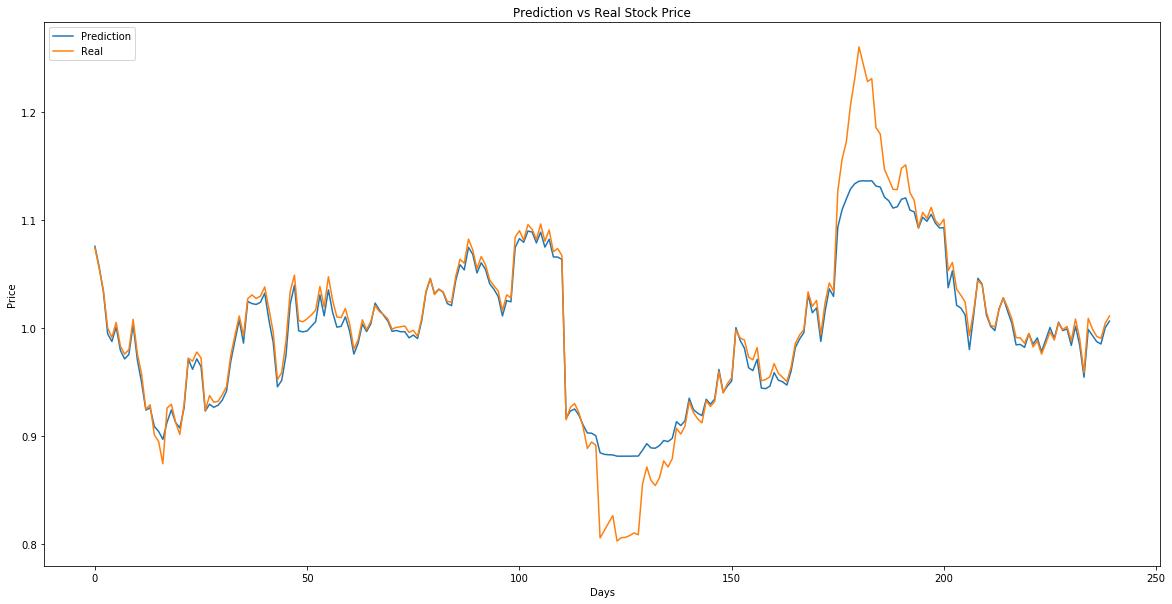

In [16]:
plt.figure(figsize=(20,10))
plt.plot(y_pred_org)
plt.plot(y_test_t_org)
plt.title('Prediction vs Real Stock Price')
plt.ylabel('Price')
plt.xlabel('Days')
plt.legend(['Prediction', 'Real'], loc='upper left')
plt.show()